# top-down and bottom-up likelihoods

In [2]:
import numpy as np
import os, sys

# project_root = os.getcwd()
project_root = os.path.abspath("")  # alternative
base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from utils import remove_all_ticks_and_labels

Suppose we have a roughly trimodal manifold as our underlying data distribution. The "S" shaped manifold has an associated context cue $c_1$.  

size of the training set is 3000
torch.Size([3000, 3])


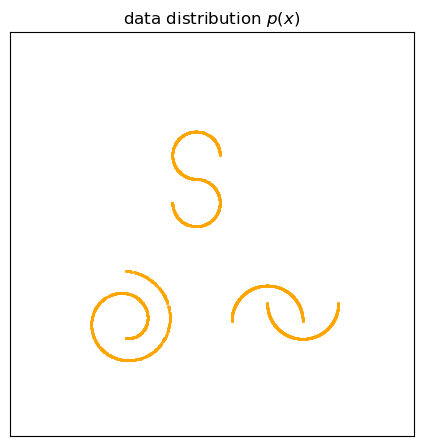

In [3]:
# load the dataset
from dataset_utils import load_trimodal_data
sample_size = int(1e3)

offsets = [[0,0], [4,0], [2,4]]
dataset = load_trimodal_data(sample_size, offsets, noise=0)

lim = 1.5
lims=[-lim-.1, lim+.1]
from plot import plot_data_distribution
plot_data_distribution(dataset, lims)

print(dataset.shape)

perform variable inference using a combination of top-down and bottom-up likelihood signals. 

In [4]:
from utils import select_model
from likelihood_utils import perform_variable_inference

prior_sampler = select_model('unconditional-dendritic', 42)[0]
classifier = select_model('noisy-image-classifier-with-noise-info', 2)[0]

v = np.array([[2, -5]]).T
label = 2
constraint_sigma = 0.035
s_bu = 0.015
s_td = 0.2
n_steps = 100
sample_size = 2e2

mode = 'neither'  # 'top-down' or 'bottom-up' or 'both' or 'neither'
x_neither, _ = perform_variable_inference(prior_sampler, classifier, v, mode, label, constraint_sigma, s_bu, s_td, n_steps, sample_size, normalized_beta_schedule=True)

mode = 'bottom-up'  # 'top-down' or 'bottom-up' or 'both' or 'neither'
x_bu, _ = perform_variable_inference(prior_sampler, classifier, v, mode, label, constraint_sigma, s_bu, s_td, n_steps, sample_size, normalized_beta_schedule=True)

mode = 'top-down'  # 'top-down' or 'bottom-up' or 'both' or 'neither'
x_td, _ = perform_variable_inference(prior_sampler, classifier, v, mode, label, constraint_sigma, s_bu, s_td, n_steps, sample_size, normalized_beta_schedule=True)

mode = 'both'  # 'top-down' or 'bottom-up' or 'both' or 'neither'
x_both, _ = perform_variable_inference(prior_sampler, classifier, v, mode, label, constraint_sigma, s_bu, s_td, n_steps, sample_size, normalized_beta_schedule=True)


model loaded!
model loaded!
prior-only mode
bottom-up mode
top-down mode
both mode


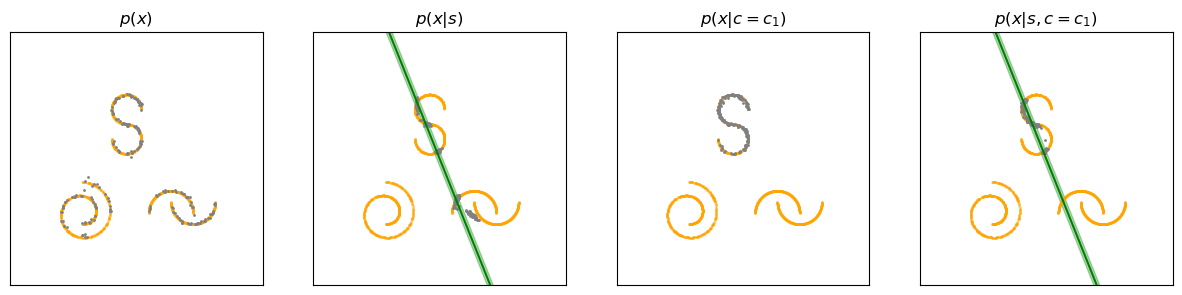

In [5]:
from plot import draw_constraint_line

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
ax = axes[0]
ax.scatter(*dataset[:, :2].T, s=1, alpha=0.2, c='orange')
ax.scatter(*x_neither[-1, :, :2].T, s=1, c='grey')
ax.set(title='$p(x)$')

ax = axes[1]
draw_constraint_line(ax, v, constraint_sigma)
ax.scatter(*dataset[:, :2].T, s=1, alpha=0.2, c='orange')
ax.scatter(*x_bu[-1, :, :2].T, s=1, c='grey')
ax.set(title='$p(x|s)$')

ax = axes[2]
ax.scatter(*dataset[:, :2].T, s=1, alpha=0.2, c='orange')
ax.scatter(*x_td[-1, :, :2].T, s=1, c='grey')
ax.set(title='$p(x|c=c_1)$')

ax = axes[3]
draw_constraint_line(ax, v, constraint_sigma)
ax.scatter(*dataset[:, :2].T, s=1, alpha=0.2, c='orange')
ax.scatter(*x_both[-1, :, :2].T, s=1, c='grey')
ax.set(title='$p(x|s, c=c_1)$')

for a in axes:
    remove_all_ticks_and_labels(a)
    a.set(xlim=lims, ylim=lims, aspect='equal')

## flow fields

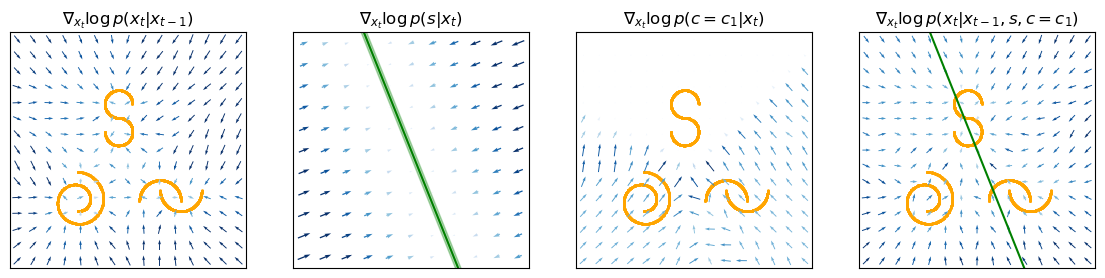

In [6]:
num_vectors_per_dim=15
t=0

# ----------------- calculate flow field for diffusion model ----------------- #
from likelihood_utils import calculate_prior_score_flow_field
score_xs_prior, score_ys_prior, color_prior = calculate_prior_score_flow_field(prior_sampler, lim, num_vectors_per_dim, t=3/100)

# --------------- calculate flow field for the likelihood model -------------- #
from likelihood_utils import compute_occlusion_score_flow_field
M = v / np.linalg.norm(v)
Mm = M @ M.T
Mm = torch.from_numpy(Mm).float()
x_hyps, scores, color_bu = compute_occlusion_score_flow_field(Mm)

# -------------------- calculate flow field for classifier ------------------- #
from likelihood_utils import compute_classifier_score_flow_field
score_xs_td, score_ys_td, color_td = compute_classifier_score_flow_field(classifier, lim, num_vectors_per_dim, t, label)

# --------------- calculate flow field for the joint posterior --------------- #
from likelihood_utils import compute_joint_posterior_score_flow_field
score_xs_post, score_ys_post, color_post = compute_joint_posterior_score_flow_field(prior_sampler, classifier, Mm, lim, num_vectors_per_dim, t, label, s_bu, s_td)


# ----------------------------------- plot ----------------------------------- #
fig, axes = plt.subplots(1, 4, figsize=(14, 7))
ax = axes[0]
ax.scatter(*dataset[:, :2].T, s=1, alpha=0.8, c='orange')
q = ax.quiver(np.linspace(-lim, lim, num_vectors_per_dim), np.linspace(-lim, lim, num_vectors_per_dim), 
          score_xs_prior, score_ys_prior, 
          color_prior,
          cmap='Blues',
          angles='xy', scale_units='xy', pivot='mid',
          scale=13,
          clim=(0, 3)
          )
ax.set(title='$\\nabla_{x_t} \log p(x_t|x_{t-1})$')

ax = axes[1]
draw_constraint_line(ax, v, constraint_sigma)
ax.quiver(*x_hyps.T, *scores.T,
            color_bu,
            cmap="Blues",
            angles = 'xy',
            scale_units = 'width',
            scale = 25,
            pivot = 'mid',
            clim=(-.05, 1.4)
            )
ax.set(title='$\\nabla_{x_t} \log p(s|x_{t})$')

ax = axes[2]
ax.scatter(*dataset[:, :2].T, s=1, alpha=0.8, c='orange')
ax.quiver(np.linspace(-lim, lim, num_vectors_per_dim), np.linspace(-lim, lim, num_vectors_per_dim),
          score_xs_td, score_ys_td, 
          color_td,
          cmap='Blues',
          angles='xy', scale_units='xy', pivot='mid',
          scale=17,
          clim=(0, 10)
          )
ax.set(title='$\\nabla_{x_t} \log p(c=c_1|x_{t})$')

ax = axes[3]
ax.scatter(*dataset[:, :2].T, s=1, alpha=0.8, c='orange')
draw_constraint_line(ax, v, constraint_sigma, show_stdev=False)
ax.quiver(np.linspace(-lim, lim, num_vectors_per_dim), np.linspace(-lim, lim, num_vectors_per_dim), 
          score_xs_post, score_ys_post, 
          color_post,
          cmap='Blues',
          angles='xy', scale_units='xy', pivot='mid',
          scale=15,
          clim=(0, 4)
          )
ax.set(title='$\\nabla_{x_t} \log p(x_t|x_{t-1}, s, c=c_1)$')


for a in axes:
    a.set(xlim=lims, ylim=lims)
    a.set_aspect('equal')
    remove_all_ticks_and_labels(a)